In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np



db = mysql.connector.connect(host="localhost",
                             username = "root",
                            password = "1045",
                            database ="ecommerce")
cur = db.cursor()

# list all unique cities where customers are located.

In [53]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)

df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017.

In [9]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)= 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]


('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [24]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["category", "sales"])
df

,category,sales
0,PERFUMERY,3040431.96
1,FURNITURE DECORATION,8581058.35
2,TELEPHONY,2921292.30
3,BED TABLE BATH,10275322.03
4,AUTOMOTIVE,5113765.99
...,...,...
69,CDS MUSIC DVDS,7196.58
70,LA CUISINE,17481.18
71,FASHION CHILDREN'S CLOTHING,4714.02
72,PC GAMER,13046.58


# calculate the percentage of orders that were paid in installments.

In [35]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments
"""
cur.execute(query)

data = cur.fetchall()

data
"the percentage of orders that were paid in installments", data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

# calculate the number of orders per month in 2018

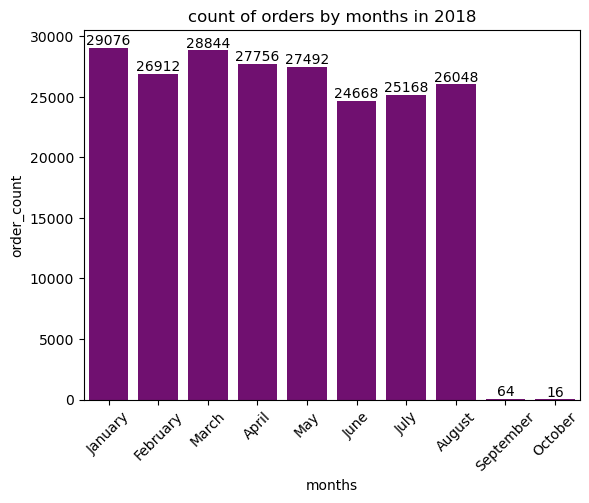

In [15]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where(order_purchase_timestamp) = 2018
group by months 
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["months"], y=df["order_count"], data=df, order = o, color="purple")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =45)
plt.title("count of orders by months in 2018")
plt.show()

# count the number of customers from each state.

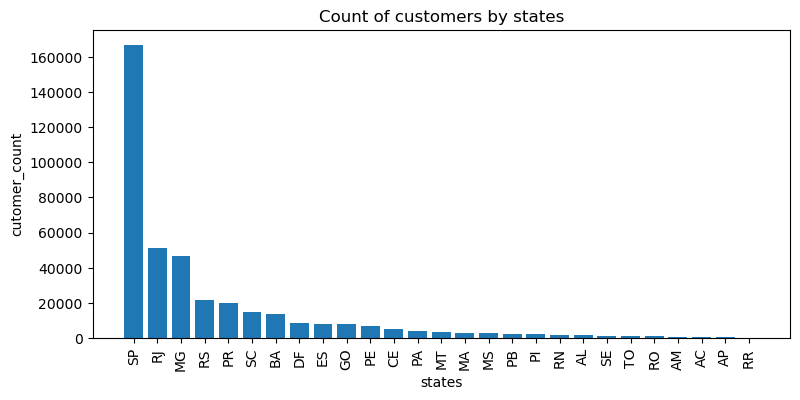

In [18]:
query = """select customer_state, count(customer_id)
from customers group by customer_state
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize =(9,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("cutomer_count")
plt.title("Count of customers by states")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [37]:
query ="""WITH count_per_order AS 
    (SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id)


SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city order by average_orders desc
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["customer city", "average products/orders"])
df.head(10)

,customer city,average products/orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


# calculate the percentage of total revenue contributed by each product category.

In [11]:
query =""" select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""
cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns =["category","percentage distribution"])

df.head(10)

,category,percentage distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78
5,SPORT LEISURE,26.09
6,HOUSEWARES,20.52
7,AUTOMOTIVE,15.97
8,GARDEN TOOLS,15.71
9,COOL STUFF,14.61


# Identify the correlation between the product price and the number of times the product has been purchased.


In [28]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns =["category","order_count", "price"])

arr1 = df["order_count"]

arr2 = df["price"]

a = np.corrcoef(arr1, arr2)
print("the correlation between the product price and the number of times the it has been purchased is", a[0][1])

the correlation between the product price and the number of times the it has been purchased is -0.1063151416715756


# calculate the total revenue generated by each seller, and rank them by revenue.

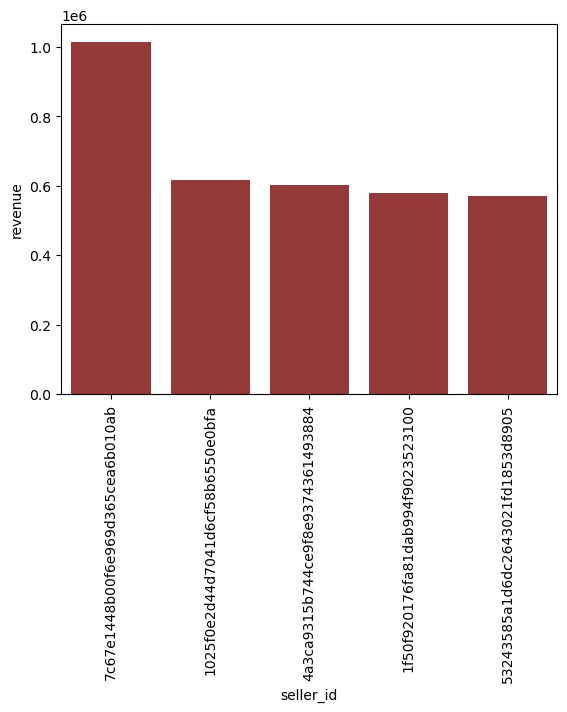

In [51]:
query = """
SELECT *,
       DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT order_items.seller_id, 
           SUM(payments.payment_value) AS revenue
    FROM order_items
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["seller_id","revenue","rank"])

df = df.head()

sns.barplot(x="seller_id", y="revenue", data=df, color ="brown")

plt.xticks(rotation= 90)

plt.show()

# calculate the moving average of order values for each customer over their order history.

In [70]:
query ="""select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp","price","mov_avg"])

df

,customer_id,order_purchase_timestamp,price,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
831083,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831084,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831085,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831086,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# calculate the cummulative sales per month each year.

In [85]:
query= """select years, months, payment, sum(payment)
over (order by years,months) cummulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments 
on orders.order_id = payments.order_id
group by years, months order by years,months) as a"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["years","months","price","cummulative_sales"])
pd.options.display.float_format = '{:.2f}'.format
print(df)



    years  months      price  cummulative_sales
0    2016       9    2017.92            2017.92
1    2016      10  472723.84          474741.76
2    2016      12     156.96          474898.72
3    2017       1 1107904.32         1582803.04
4    2017       2 2335264.08         3918067.12
5    2017       3 3598908.80         7516975.92
6    2017       4 3342304.24        10859280.16
7    2017       5 4743350.56        15602630.72
8    2017       6 4090211.04        19692841.76
9    2017       7 4739063.36        24431905.12
10   2017       8 5395170.56        29827075.68
11   2017       9 5822099.60        35649175.28
12   2017      10 6237423.04        41886598.32
13   2017      11 9559062.40        51445660.72
14   2017      12 7027211.84        58472872.56
15   2018       1 8920033.43        67392905.99
16   2018       2 7939706.72        75332612.71
17   2018       3 9277216.96        84609829.67
18   2018       4 9286283.85        93896113.52
19   2018       5 9231857.21       10312

# Calculate the year-over-year growth rate of total sales.

In [28]:
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM 
        orders 
    JOIN 
        payments 
    ON 
        orders.order_id = payments.order_id
    GROUP BY 
        years 
    ORDER BY 
        years
)
SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / 
    LAG(payment, 1) OVER (ORDER BY years)) * 100 AS yoy_growth 
FROM 
    a
"""
cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["years", "yoy % growth"])

df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# calculate the retention of the customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [41]:
query = """
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM 
        customers 
    JOIN 
        orders
    ON 
        customers.customer_id = orders.customer_id
    GROUP BY 
        customers.customer_id
),

b AS (
    SELECT 
        a.customer_id, 
        COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
    FROM 
        a 
    JOIN 
        orders
    ON 
        orders.customer_id = a.customer_id
    AND 
        orders.order_purchase_timestamp > a.first_order
    AND 
        orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY 
        a.customer_id
)

SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / COUNT(DISTINCT b.customer_id)) AS percentage
FROM 
    a 
LEFT JOIN 
    b
ON 
    a.customer_id = b.customer_id;
"""
cur.execute(query)

data = cur.fetchall()

data


[(None,)]

# Identify the top 3 customers who spent the most money in each year.

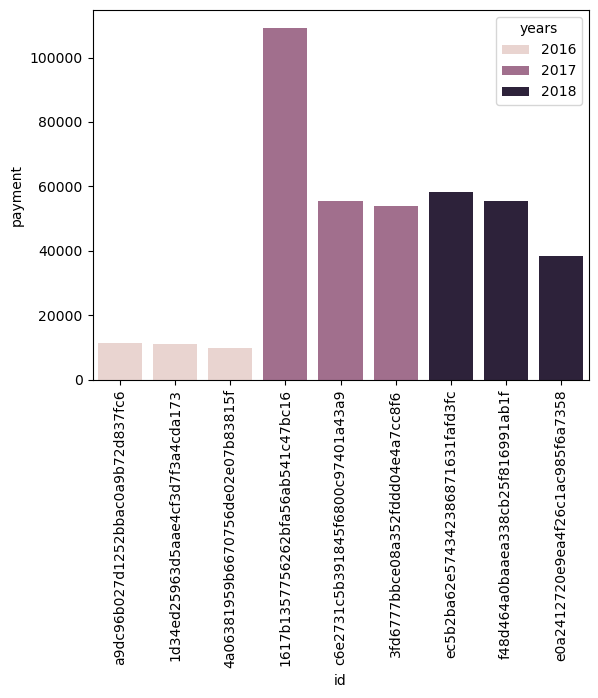

In [50]:
query = """
SELECT 
    years, customer_id, payment, d_rank
FROM 
    (SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders 
    JOIN 
        payments 
    ON 
        orders.order_id = payments.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp),
        orders.order_id, 
        orders.customer_id) AS a
WHERE 
    d_rank <= 3
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","id","payment", "rank"])
sns.barplot(x="id",y="payment",data =df, hue ="years")
plt.xticks(rotation =90)
plt.show()